In [ ]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from tqdm.notebook import trange, tqdm
from torchvision import datasets, transforms
import os
import copy
import time
import ntpath
from typing import cast, Tuple
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import os, sys

import matplotlib.pyplot as plt
from matplotlib import style

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)


PyTorch Version:  1.7.0+cu101
Torchvision Version:  0.8.1+cu101


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Data Directory
!ls gdrive/Shareddrives/Motion_WaveFusion/data/sample

train  val


# Training Parameters

In [ ]:
threeD = True # Set to true if training 3DCNN
save = False # If true save model
save_as = 'gdrive/My Drive/LEMON/model/LEMON_MBNODEL25' #directory to save files. ~/NAME_OF_File
load_wts = False # If true load pretrained model weights
path_wts = '' # Path to weights for loading pretrained model


epochs = 60 #number of epochs. this one works - changes the number of train/val epochs when model is running
data_dir = "gdrive/Shareddrives/Motion_WaveFusion/data/sample" # path to data files
batch_size = 20 #  batch_size
learning_rate = 0.001 # learning rate
weight_decay = 0.00075 # weight decay

# Dataset code

In [ ]:
class Motion_Dataset(Dataset):

    def __init__(self, root_dir, threeD = False, transform=None):
        """
        Args:
            root_dir (string): root directory with subdirectory containing .npy files of eeg readings class 1-4.
            threeD (boolean): if true, convert 63x48x2000 morlet wavelet tensors to 1x63x48x2000 for 3D CNN.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        classes, class_to_idx = self._find_classes(root_dir)
        self.extensions = ".npy"
        self.transform = transform
        self.threeD = threeD
        self.samples = self.make_dataset(root_dir, self.extensions, class_to_idx)
        self.targets = [s[1] for s in self.samples]

    def has_file_allowed_extension(self, filename, extensions):
        """Checks if a file is an allowed extension.

        Args:
            filename (string): path to a file

        Returns:
            bool: True if the filename ends with a known image extension
        """
        
        filename_lower = filename.lower()
        return any(filename_lower.endswith(ext) for ext in extensions)
    
    def is_valid_file(self, x: str):
            return self.has_file_allowed_extension(x, cast(Tuple[str, ...], self.extensions))
    
    def _find_classes(self, dir: str):
        """
        Finds the class folders in a dataset.

        Args:
            dir (string): Root directory path.

        Returns:
            tuple: (classes, class_to_idx) where classes are relative to (dir), and class_to_idx is a dictionary.

        Ensures:
            No class is a subdirectory of another.
        """
        classes = [d.name for d in os.scandir(dir) if d.is_dir()]
        classes.sort()
        class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}
        return classes, class_to_idx       
    
    def make_dataset(self, root_dir, extensions, class_to_idx):
        """creates a list of paths to data in root data directory

        Args:
            root_dir (string): root directory with subdirectory containing .npy files of eeg readings class 1-4.
            extensions: extensions allowed.
            class_to_idx: dictionary of classes and numerics.

        Returns:
            instances (list): list of tuples with path to .npy file and target.
        """

        instances = []

        for target_class in sorted(class_to_idx.keys()):
            class_index = class_to_idx[target_class]
            target_dir = os.path.join(root_dir, target_class)
            if not os.path.isdir(target_dir):
                continue
            for root, _, fnames in sorted(os.walk(target_dir, followlinks=True)):
                for fname in sorted(fnames):
                    path = os.path.join(root, fname)
                    if self.is_valid_file(path):
                        item = path, class_index
                        instances.append(item)
        return instances

    def __getitem__(self, index: int):
            """
            Args:
                index (int): Index

            Returns:
                tuple: (sample, target) where target is class_index of the target class.
            """
            path, target = self.samples[index]
            sample = np.load(path)
            sample = torch.FloatTensor( sample )
            if self.transform is not None:
                sample = self.transform(sample)
                
            if self.threeD:
                sample = torch.unsqueeze(sample, 0)

            return sample, target
    
    def __len__(self):
        return len(self.samples)

# Dataloader code

In [ ]:
def motion_collate(batch):
    """
    custom collate function for turning a batch of scale-time wavelet transforms types into 
    (batch_size)x17x48x2000 TENSORS with target
    
    Args:
        Batch: batch of Lemon STFT Data
    
    Returns:
        tuple: (tesseractTransform(sample(index)), target) where target is class_index of the target class.
    """

    data = torch.stack([item[0] for item in batch])  # just form a tensor
    #target = torch.stack([item[1] for item in batch])
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    return [data, target]

In [ ]:
#data loader
def motion_dataloader(dataset, batch_size: int, transform = None, shuffle=False):
    """
    Custom data loader returns DataLoader for Motion Dataset
    `1
    Args:
        root: path to data. ex: ~/SMNI_TRAINTEST_DATA/train/
        batch_size: batch size
        shuffle: shuffle data
    Returns:
        Dataloader with time frequency/frequency data
    """
    return DataLoader(dataset=dataset, collate_fn=motion_collate, batch_size=10, shuffle=shuffle)

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        #transforms.ToTensor()
    ]),
}

In [ ]:
motion_datasets = {x: Motion_Dataset(os.path.join(data_dir, x),threeD = threeD, transform=None) for x in ['train', 'val']}
data_loaders_dict = {x: motion_dataloader(dataset=motion_datasets[x], batch_size=batch_size, transform = None, shuffle=True) for x in ['train', 'val']}

# Model Training and Validation Code 

In [ ]:
def train_model(model, dataloaders, loss, optimizer, save_as = None,save = False, epochs=epochs, load_wts = False, wts = None):
    """ train a model with given params
    Args:
        model: model, extends torch.nn
        dataloaders: dataloader dictionary of the form {"train": dataloader_train_data
                                                        "val": dataloader_val_data
                                                        }
        optimizer: optimization func.
        wts_path: path to torch.nn.Module.load_state_dict for "model"
        epochs: number of epochs to train model
        load_wts: bool true if loading a state dict, false otherwhise
        
    
    Return:
        Tuple: model with trained weights and validation training statistics(epoch loss, accuracy)
    """
    
    #isntantiate validation history, base model waits and loss
    val_loss_history = []
    train_loss_history = []

    val_acc_history = []
    train_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_optim = None
    #load moadel weigthts
    if load_wts == True:
        print("loading from: "+path_wts)
        checkpoint = torch.load(path_wts)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print("acc from prev:{:.4f}".format(checkpoint['best_acc']))  
    
    #train model
    print("num training points  : {}".format( len(dataloaders["train"].dataset)))
    print("num validation points: {}".format( len(dataloaders["val"].dataset)))
    
    for epoch in tqdm(range(epochs),desc='epoch', leave = False):
        #import pdb; pdb.set_trace()
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode 

            running_loss = 0.0
            running_corrects = 0  
            
            for batch in tqdm(dataloaders[phase],desc='batch', leave = False):
                #send inputs and labels to device
                inputs = batch[0].to(device)
                labels = batch[1].to(device)

                #clear gradients rom previous batch
                optim.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    # Get model outputs and calculate loss for train
                    if phase == 'train':
                        preds = model(inputs)
                        loss = lossfun(preds, labels)
                        
                        
                    # Get model outputs and calculate loss for val
                    else:
                        preds = model(inputs)
                        loss = lossfun(preds, labels) 

                    #get predictions
                    _, preds = torch.max(preds, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        #back propagate loss
                        loss.backward()
                        #update weights
                        optim.step()

                    #running statistics       
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

            time_elapsed = time.time() - since

            #update epoch loss and acc
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
                  
            #track validation loss and acc
            tqdm.write('{}: {} epoch_loss: {:.10f} epoch_acc: {:.4f} time: {:.4f}'.format(epoch,phase, epoch_loss, epoch_acc,time_elapsed))
            
            #update training history
            if phase == 'val':
                val_loss_history.append(epoch_loss)
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc)
            #update best weights    
            if phase == 'val' and best_acc > epoch_acc:
                print("best model updated")
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_optim = copy.deepcopy(optimizer.state_dict())
            
        #save model
        if epoch ==epochs-1 and save:
            torch.save({
            'best_acc': best_acc,
            'model_state_dict': best_model_wts,
            'optimizer_state_dict': best_optim,
            'best_acc': best_acc,
            }, save_as+"_ep={}.tar".format(epoch))  

    model.load_state_dict(best_model_wts)
    history = (val_loss_history, val_acc_history, train_loss_history, train_acc_history)
    return model, history

# Define Model

## 2D Model

In [ ]:
#Model 
class TwoDimCNN(nn.Module):
  def __init__(self):
    super(TwoDimCNN, self).__init__()

    self.conv1 = nn.Conv2d(63, 126, kernel_size=(4, 6), stride=(2, 2), padding=(1, 0))
    self.a1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d((1,2))

    self.conv2 = nn.Conv2d(126, 252, (4, 4), stride=(2, 2), padding=(1, 0))
    self.a2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool2d((1,2))

    self.conv3 = nn.Conv2d(252, 504, (4, 3), stride=(2, 1), padding=(1, 0))
    self.a3 = nn.ReLU()
    self.maxpool3 = nn.MaxPool2d((1,2))

    self.conv4 = nn.Conv2d(504, 1008, (2, 3), stride=(2, 1), padding=(1, 0))
    self.a4 = nn.ReLU()
    self.maxpool4 = nn.MaxPool2d((1,2))

    self.conv5 = nn.Conv2d(1008, 1008, (2, 2), stride=(2, 1), padding=(0, 0))
    self.a5 = nn.ReLU()
    self.maxpool5 = nn.MaxPool2d((2,2))

    self.fc1 = nn.Linear(1008, 128)
    self.a6 = nn.ReLU()

    self.fc2 = nn.Linear(128, 2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.a1(x)
    x = self.maxpool1(x)

    x = self.conv2(x)
    x = self.a2(x)
    x = self.maxpool2(x)

    x = self.conv3(x)
    x = self.a3(x)
    x = self.maxpool3(x)

    x = self.conv4(x)
    x = self.a4(x)
    x = self.maxpool4(x)

    x = self.conv5(x)
    x = self.a5(x)
    x = self.maxpool5(x)

    x = x.view(-1, 1008)

    x = self.fc1(x)
    x = self.a6(x)

    x = self.fc2(x)

    return x

## 3D Model

In [ ]:
class ThreeDimCNN(nn.Module):
  def __init__(self):
    super(ThreeDimCNN, self).__init__()

    self.conv1 = nn.Conv3d(1, 4, (3, 4, 6), stride=(2,2, 2), padding=(0,1, 0))
    self.a1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool3d((1,1,2))

    self.conv2 = nn.Conv3d(4, 8, (3, 4, 4), stride=(2, 2, 2), padding=(0,1, 0))
    self.a2 = nn.ReLU()
    self.maxpool2 = nn.MaxPool3d((1,1,2))

    self.conv3 = nn.Conv3d(8, 16, (3, 4, 3), stride=(2, 2, 1), padding=(0, 1, 0))
    self.a3 = nn.ReLU()
    self.maxpool3 = nn.MaxPool3d((1,1,2))

    self.conv4 = nn.Conv3d(16, 32, (3, 2, 3), stride=(2, 2, 1), padding=(0, 1, 0))
    self.a4 = nn.ReLU()
    self.maxpool4 = nn.MaxPool3d((1,1,2))

    self.conv5 = nn.Conv3d(32, 32, (2,2, 2), stride=(1,2, 1), padding=(0, 0, 0))
    self.a5 = nn.ReLU()
    self.maxpool5 = nn.MaxPool3d((2,2,2))

    self.fc1 = nn.Linear(32, 2)

  def forward(self, x):
    x = self.conv1(x)
    x = self.a1(x)
    x = self.maxpool1(x)

    x = self.conv2(x)
    x = self.a2(x)
    x = self.maxpool2(x)

    x = self.conv3(x)
    x = self.a3(x)
    x = self.maxpool3(x)

    x = self.conv4(x)
    x = self.a4(x)
    x = self.maxpool4(x)

    x = self.conv5(x)
    x = self.a5(x)
    x = self.maxpool5(x)

    x = x.view(-1, 32)

    x = self.fc1(x)

    return x


In [ ]:
#set to train w/ GPU if available else cpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
model = ThreeDimCNN()
# Send the model to GPU
model = model.to(device)
lossfun = nn.CrossEntropyLoss()
# optim = torch.optim.SGD(model.parameters(),lr=0.001, momentum = 0.0005, weight_decay = 0.00075)
optim = torch.optim.Adam(model.parameters(), lr=learning_rate ,weight_decay = weight_decay)

# Train

In [ ]:
model, history = train_model(model = model, dataloaders = data_loaders_dict, loss = lossfun, save = save, save_as = save_as, optimizer = optim, epochs=epochs,load_wts = load_wts, wts = path_wts)

# num training point is always 40 below when cell runs. assuming this is 40 bc 20 train + 20 val files in the drive.
# not sure where validation points comes from. why is it 10 and not 20?

num training points  : 40
num validation points: 10


0: train epoch_loss: 0.7207014263 epoch_acc: 0.3750 time: 0.9420


0: val epoch_loss: 0.6903508902 epoch_acc: 0.7000 time: 1.1257


1: train epoch_loss: 0.7001071572 epoch_acc: 0.4500 time: 0.8579


1: val epoch_loss: 0.6957064271 epoch_acc: 0.5000 time: 1.0463


2: train epoch_loss: 0.6957396567 epoch_acc: 0.5000 time: 0.8548


2: val epoch_loss: 0.6977869272 epoch_acc: 0.5000 time: 1.0417


3: train epoch_loss: 0.6945161521 epoch_acc: 0.5000 time: 0.8475


3: val epoch_loss: 0.6961034536 epoch_acc: 0.5000 time: 1.0271


4: train epoch_loss: 0.6894581467 epoch_acc: 0.5000 time: 0.8366


4: val epoch_loss: 0.6938896775 epoch_acc: 0.5000 time: 1.0163


5: train epoch_loss: 0.6831422001 epoch_acc: 0.5000 time: 0.8699


5: val epoch_loss: 0.6918282509 epoch_acc: 0.5000 time: 1.0497


6: train epoch_loss: 0.6754238605 epoch_acc: 0.5250 time: 0.8828


6: val epoch_loss: 0.6908728480 epoch_acc: 0.5000 time: 1.0691


7: train epoch_loss: 0.6686175168 epoch_acc: 0.6500 time: 0.8704


7: val epoch_loss: 0.6928948164 epoch_acc: 0.5000 time: 1.0571


8: train epoch_loss: 0.6457448155 epoch_acc: 0.6750 time: 0.8775


8: val epoch_loss: 0.6887908578 epoch_acc: 0.5000 time: 1.0690


9: train epoch_loss: 0.6333830357 epoch_acc: 0.6750 time: 0.8687


9: val epoch_loss: 0.6756040454 epoch_acc: 0.7000 time: 1.0731


10: train epoch_loss: 0.5835196376 epoch_acc: 0.8500 time: 0.8930


10: val epoch_loss: 0.6710876822 epoch_acc: 0.6000 time: 1.0778


11: train epoch_loss: 0.5173955038 epoch_acc: 0.8500 time: 0.8671


11: val epoch_loss: 0.7048429251 epoch_acc: 0.6000 time: 1.0514


12: train epoch_loss: 0.4389772043 epoch_acc: 0.9250 time: 0.8670


12: val epoch_loss: 0.7174320221 epoch_acc: 0.6000 time: 1.0498


13: train epoch_loss: 0.2723987624 epoch_acc: 0.9250 time: 0.9088


13: val epoch_loss: 0.7868520021 epoch_acc: 0.6000 time: 1.0991


14: train epoch_loss: 0.1544587202 epoch_acc: 1.0000 time: 0.8810


14: val epoch_loss: 0.8258479238 epoch_acc: 0.7000 time: 1.0706


15: train epoch_loss: 0.0906766211 epoch_acc: 1.0000 time: 0.8711


15: val epoch_loss: 0.9041553736 epoch_acc: 0.6000 time: 1.0707


16: train epoch_loss: 0.0244646925 epoch_acc: 1.0000 time: 0.8613


16: val epoch_loss: 1.1979156733 epoch_acc: 0.6000 time: 1.0553


17: train epoch_loss: 0.0076626766 epoch_acc: 1.0000 time: 0.8601


17: val epoch_loss: 1.2571949959 epoch_acc: 0.6000 time: 1.0423


18: train epoch_loss: 0.0021624762 epoch_acc: 1.0000 time: 0.8775


18: val epoch_loss: 1.3114818335 epoch_acc: 0.5000 time: 1.0627


19: train epoch_loss: 0.0010731252 epoch_acc: 1.0000 time: 0.8763


19: val epoch_loss: 1.8038914204 epoch_acc: 0.6000 time: 1.0583


20: train epoch_loss: 0.0004198997 epoch_acc: 1.0000 time: 0.8755


20: val epoch_loss: 2.2536196709 epoch_acc: 0.7000 time: 1.0652


21: train epoch_loss: 0.0004140193 epoch_acc: 1.0000 time: 0.8705


21: val epoch_loss: 2.2904031277 epoch_acc: 0.7000 time: 1.0575


22: train epoch_loss: 0.0001439783 epoch_acc: 1.0000 time: 0.8565


22: val epoch_loss: 2.1221449375 epoch_acc: 0.6000 time: 1.0385


23: train epoch_loss: 0.0000587440 epoch_acc: 1.0000 time: 0.9145


23: val epoch_loss: 2.0148446560 epoch_acc: 0.6000 time: 1.1077


24: train epoch_loss: 0.0000585568 epoch_acc: 1.0000 time: 0.8716


24: val epoch_loss: 1.9609111547 epoch_acc: 0.6000 time: 1.0624


25: train epoch_loss: 0.0000630691 epoch_acc: 1.0000 time: 0.8520


25: val epoch_loss: 1.9509283304 epoch_acc: 0.6000 time: 1.0385


26: train epoch_loss: 0.0000582278 epoch_acc: 1.0000 time: 0.8564


26: val epoch_loss: 1.9716799259 epoch_acc: 0.6000 time: 1.0369


27: train epoch_loss: 0.0000499422 epoch_acc: 1.0000 time: 0.8651


27: val epoch_loss: 2.0163760185 epoch_acc: 0.6000 time: 1.0477


28: train epoch_loss: 0.0000382633 epoch_acc: 1.0000 time: 0.8648


28: val epoch_loss: 2.0614771843 epoch_acc: 0.6000 time: 1.0598


29: train epoch_loss: 0.0000348962 epoch_acc: 1.0000 time: 0.8867


29: val epoch_loss: 2.1128821373 epoch_acc: 0.6000 time: 1.0798


30: train epoch_loss: 0.0000298219 epoch_acc: 1.0000 time: 0.8962


30: val epoch_loss: 2.1494128704 epoch_acc: 0.6000 time: 1.0747


31: train epoch_loss: 0.0000286955 epoch_acc: 1.0000 time: 0.8646


31: val epoch_loss: 2.1767501831 epoch_acc: 0.6000 time: 1.0500


32: train epoch_loss: 0.0000283737 epoch_acc: 1.0000 time: 0.8788


32: val epoch_loss: 2.1936268806 epoch_acc: 0.6000 time: 1.0564


33: train epoch_loss: 0.0000284810 epoch_acc: 1.0000 time: 0.8951


33: val epoch_loss: 2.2047426701 epoch_acc: 0.6000 time: 1.0809


34: train epoch_loss: 0.0000281770 epoch_acc: 1.0000 time: 0.8557


34: val epoch_loss: 2.2040998936 epoch_acc: 0.6000 time: 1.0410


35: train epoch_loss: 0.0000278909 epoch_acc: 1.0000 time: 0.8517


35: val epoch_loss: 2.2006504536 epoch_acc: 0.6000 time: 1.0386


36: train epoch_loss: 0.0000276138 epoch_acc: 1.0000 time: 0.8796


36: val epoch_loss: 2.1922652721 epoch_acc: 0.6000 time: 1.0729


37: train epoch_loss: 0.0000273128 epoch_acc: 1.0000 time: 0.8546


37: val epoch_loss: 2.1830909252 epoch_acc: 0.6000 time: 1.0408


38: train epoch_loss: 0.0000270685 epoch_acc: 1.0000 time: 0.8750


38: val epoch_loss: 2.1728310585 epoch_acc: 0.6000 time: 1.0620


39: train epoch_loss: 0.0000270089 epoch_acc: 1.0000 time: 0.8845


39: val epoch_loss: 2.1623938084 epoch_acc: 0.6000 time: 1.0690


40: train epoch_loss: 0.0000267258 epoch_acc: 1.0000 time: 0.8804


40: val epoch_loss: 2.1567785740 epoch_acc: 0.6000 time: 1.0614


41: train epoch_loss: 0.0000266990 epoch_acc: 1.0000 time: 0.8767


41: val epoch_loss: 2.1538014412 epoch_acc: 0.6000 time: 1.0647


42: train epoch_loss: 0.0000266573 epoch_acc: 1.0000 time: 0.8566


42: val epoch_loss: 2.1480507851 epoch_acc: 0.6000 time: 1.0562


43: train epoch_loss: 0.0000264695 epoch_acc: 1.0000 time: 0.8817


43: val epoch_loss: 2.1496043205 epoch_acc: 0.6000 time: 1.0596


44: train epoch_loss: 0.0000264964 epoch_acc: 1.0000 time: 0.8727


44: val epoch_loss: 2.1517643929 epoch_acc: 0.6000 time: 1.0599


45: train epoch_loss: 0.0000263682 epoch_acc: 1.0000 time: 0.8472


45: val epoch_loss: 2.1521909237 epoch_acc: 0.6000 time: 1.0264


46: train epoch_loss: 0.0000263325 epoch_acc: 1.0000 time: 0.8738


46: val epoch_loss: 2.1491169930 epoch_acc: 0.6000 time: 1.0560


47: train epoch_loss: 0.0000262520 epoch_acc: 1.0000 time: 0.8980


47: val epoch_loss: 2.1476109028 epoch_acc: 0.6000 time: 1.0760


48: train epoch_loss: 0.0000261745 epoch_acc: 1.0000 time: 0.8588


48: val epoch_loss: 2.1490786076 epoch_acc: 0.6000 time: 1.0413


49: train epoch_loss: 0.0000261269 epoch_acc: 1.0000 time: 0.8720


49: val epoch_loss: 2.1495554447 epoch_acc: 0.6000 time: 1.0491


50: train epoch_loss: 0.0000261149 epoch_acc: 1.0000 time: 0.8452


50: val epoch_loss: 2.1478827000 epoch_acc: 0.6000 time: 1.0257


51: train epoch_loss: 0.0000260643 epoch_acc: 1.0000 time: 0.8574


51: val epoch_loss: 2.1453642845 epoch_acc: 0.6000 time: 1.0360


52: train epoch_loss: 0.0000260613 epoch_acc: 1.0000 time: 0.8675


52: val epoch_loss: 2.1472423077 epoch_acc: 0.6000 time: 1.0445


53: train epoch_loss: 0.0000260166 epoch_acc: 1.0000 time: 0.8719


53: val epoch_loss: 2.1477224827 epoch_acc: 0.6000 time: 1.0567


54: train epoch_loss: 0.0000260256 epoch_acc: 1.0000 time: 0.8743


54: val epoch_loss: 2.1445305347 epoch_acc: 0.6000 time: 1.0612


55: train epoch_loss: 0.0000260047 epoch_acc: 1.0000 time: 0.8921


55: val epoch_loss: 2.1469881535 epoch_acc: 0.6000 time: 1.0702


56: train epoch_loss: 0.0000258855 epoch_acc: 1.0000 time: 0.8473


56: val epoch_loss: 2.1428043842 epoch_acc: 0.6000 time: 1.0332


57: train epoch_loss: 0.0000258557 epoch_acc: 1.0000 time: 0.8606


57: val epoch_loss: 2.1416251659 epoch_acc: 0.6000 time: 1.0528


58: train epoch_loss: 0.0000258080 epoch_acc: 1.0000 time: 0.8873


58: val epoch_loss: 2.1384799480 epoch_acc: 0.6000 time: 1.0773


59: train epoch_loss: 0.0000258021 epoch_acc: 1.0000 time: 0.8681


59: val epoch_loss: 2.1371593475 epoch_acc: 0.6000 time: 1.0549


## Plots

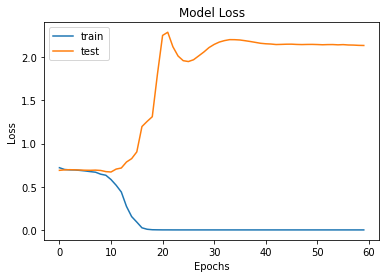

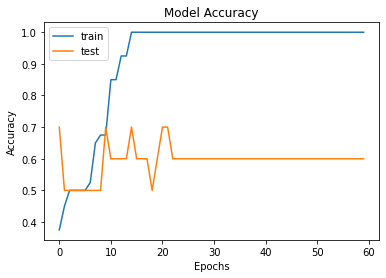

In [ ]:
# history = (val_loss_history, val_acc_history, train_loss_history, train_acc_history)
plt.plot(history[2]) # train
plt.plot(history[0]) # val
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

plt.plot(history[3]) # train
plt.plot(history[1]) # val
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()